In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 17

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.8, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:

def get_scaled_feature(X: np.array):
    m = np.mean(X, axis=0)
    s = np.std(X, axis=0)
    
    return (X - m) / s

In [6]:
X = get_scaled_feature(X)

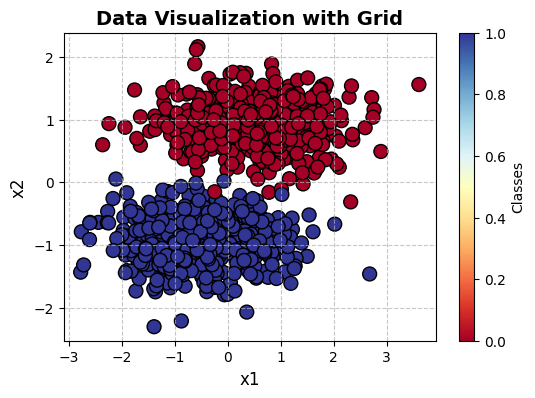

In [7]:
# let's plot the data
plt.figure(figsize=(6, 4))

# scatter plot with labels and grid
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', s=100)

# add title, labels, and grid
plt.title('Data Visualization with Grid', fontsize=14, fontweight='bold')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# display color bar to indicate classes
plt.colorbar(label='Classes')

# display the plot
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750,), (250, 2), (250,))

In [9]:

class SVM:
    def __init__(self, C=1.0):
        self.C = C  # Regularization parameter (for soft margin, though not used in this simple linear SVM)
        self.w = None
        self.b = None
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_alphas = None
    
    def fit(self, X, y):
        # Convert y from {0, 1} to {-1, 1} if needed
        y = np.where(y == 0, -1, y)
        
        # Store the training data
        self.X = X
        self.y = y
        m, n = X.shape

        # Compute the Gram matrix (Q = (y y^T) ∘ (X X^T))
        K = X @ X.T
        Q = np.outer(y, y) * K

        # Define the objective function for the QP problem
        def objective(alpha):
            # Objective function to minimize (converted from maximization form)
            return 0.5 * np.dot(alpha, np.dot(Q, alpha)) - np.sum(alpha)

        # Define the equality constraint (y^T alpha = 0)
        constraints = {
            'type': 'eq', 
            'fun': lambda alpha: np.dot(y, alpha)
        }

        # Bounds for alpha (all alpha >= 0)
        bounds = [(0, None) for _ in range(m)] 

        # Initial guess
        alpha0 = np.zeros(m)

        # Solve the QP problem using scipy.optimize.minimize
        result = minimize(objective, alpha0, bounds=bounds, constraints=constraints, method='SLSQP')
        self.alphas = result.x

        # Extract support vectors where alpha > epsilon
        epsilon = 1e-5
        support_vector_indices = np.where(self.alphas > epsilon)[0]
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.support_alphas = self.alphas[support_vector_indices]

        # Compute w 
        self.w = self.X.T @ (self.alphas * self.y)
        
        # Compute b using any support vector
        self.b = np.mean(
            [self.support_vector_labels[i] - np.dot(self.w, self.support_vectors[i]) 
                for i in range(len(self.support_alphas))]
        )

    def predict(self, X):
        # Make predictions based on the sign of the decision function
        return np.sign(np.dot(X, self.w) + self.b)

    def decision_function(self, X):
        # Compute the decision function values
        return np.dot(X, self.w) + self.b
    
    def plot_decision_boundary(self):
        # Plot the original data points
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='bwr', alpha=0.7, s=50)
        
        # Highlight the support vectors
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], 
                    s=100, facecolors='none', edgecolors='k', label='Support Vectors')
        
        # Create a grid to plot decision boundary and margins
        x_min, x_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        y_min, y_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Compute decision function values for the grid
        Z = self.decision_function(grid)
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary (where f(x) = 0)
        plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles=['-'], linewidths=1.5)
        
        # Plot the margin boundaries (where f(x) = ±1)
        plt.contour(xx, yy, Z, levels=[-1, 1], colors='k', linestyles=['--'], linewidths=1)
        
        # Customize the plot
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.title('SVM Decision Boundary with Margin and Support Vectors')
        plt.show()

In [10]:
model1 = SVM()
model1.fit(X_train, y_train)

In [11]:
model1.w, model1.b

(array([-1.55785566, -4.01839489]), 0.3244843245051492)

In [12]:
y_pred_train = model1.predict(X_train)
y_pred_train = np.where(y_pred_train == -1, 0, 1)
y_pred_test = model1.predict(X_test)
y_pred_test = np.where(y_pred_test == -1, 0, 1)

In [13]:
from sklearn.metrics import classification_report

In [14]:
# training set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       369
           1       0.99      0.99      0.99       381

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [15]:
# test set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       131
           1       0.97      1.00      0.98       119

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



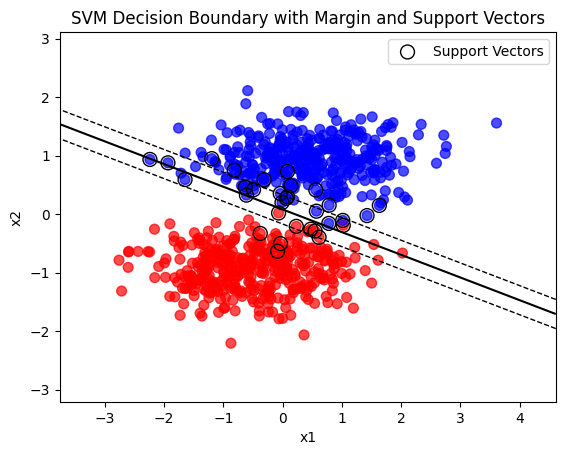

In [16]:
model1.plot_decision_boundary()

In [17]:
model1.support_vectors

array([[-1.93451346,  0.87689541],
       [-0.03923529,  0.35108381],
       [ 0.08303427,  0.72827231],
       [ 1.42551294, -0.0246138 ],
       [ 0.06403085,  0.27090373],
       [ 0.78585345,  0.15341943],
       [ 0.77991526, -0.1582737 ],
       [-0.06734796,  0.02017764],
       [ 1.02459109, -0.19113166],
       [-0.31200549,  0.5889304 ],
       [ 0.08306802,  0.29673048],
       [-2.23837996,  0.93493733],
       [-0.49046224,  0.41706105],
       [-1.6454996 ,  0.59129243],
       [-0.03501079, -0.503784  ],
       [ 0.13905478,  0.48402346],
       [ 0.23135052, -0.20887033],
       [-0.61007157,  0.3250052 ],
       [ 0.57131774,  0.05062824],
       [ 1.01598175, -0.10698336],
       [-0.81461469,  0.75078605],
       [ 0.61565647, -0.39521003],
       [-0.62974647,  0.46096201],
       [-0.3764554 , -0.32978472],
       [ 0.47622875, -0.25753303],
       [-0.00967262,  0.19770115],
       [ 0.54789926, -0.28898568],
       [ 0.56132826,  0.41376794],
       [-1.19519702,

In [18]:
model1.support_vectors.shape

(31, 2)

In [19]:
model1.alphas 

array([0.00000000e+00, 0.00000000e+00, 7.61434200e-07, 1.03270457e-09,
       0.00000000e+00, 1.08431948e-08, 8.19405966e-10, 0.00000000e+00,
       1.99986167e-09, 0.00000000e+00, 1.24973162e-09, 2.60251246e-10,
       0.00000000e+00, 1.07921362e-08, 1.11478627e-09, 1.51294486e-09,
       0.00000000e+00, 8.67334773e-09, 4.19695125e-10, 5.20247897e-10,
       0.00000000e+00, 3.24451396e-08, 1.39231836e-09, 7.21724609e-10,
       0.00000000e+00, 0.00000000e+00, 2.21840037e-10, 1.23580381e-09,
       2.79125202e-09, 0.00000000e+00, 7.43283443e-10, 4.22398524e-10,
       1.04135511e-08, 4.43776351e-09, 5.23376493e-10, 7.40001216e-10,
       0.00000000e+00, 0.00000000e+00, 1.25375908e-09, 8.64109454e-10,
       0.00000000e+00, 2.17571077e-09, 3.15571339e-10, 4.63104841e-10,
       0.00000000e+00, 2.31079949e-09, 1.16753478e-09, 7.14679402e-07,
       0.00000000e+00, 1.96085973e-08, 5.48335937e-10, 2.30524287e-10,
       8.88623011e-10, 1.28187543e-08, 0.00000000e+00, 8.26312671e-10,
      